In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%load_ext autoreload

$$\dot{\theta} = \omega$$
$$\dot{\omega} = \frac{(m+m_c)g\sin{\theta} - \cos{\theta}(u + ml\omega^2\sin{\theta})}{(4/3)(m+m_c)l - ml\cos{\theta}^2}$$
$$\dot{h} = dh$$
$$\dot{dh} = \frac{u + ml(\omega^2\sin{\theta} - \dot{\omega}\cos{\theta})}{m + m_c}$$

In [13]:
from system.pendulum import InvertedPendulumSystem, InvertedPendulumSystemCART, InvertedPendulumSystemLQR
from system.simulator import Simulator, SimulatorLimited
from models.model import GaussianPDFModel, DiscreteModel
from models.optimizer import Optimizer
from policy.policy_reinforce import PolicyREINFORCE
from simulator.monte_carlo import MonteCarloSimulationScenario, MonteCarloLQR
from models.LQR import LQR
%autoreload 2

Text(0.5, 1.0, 'Angular velocity')

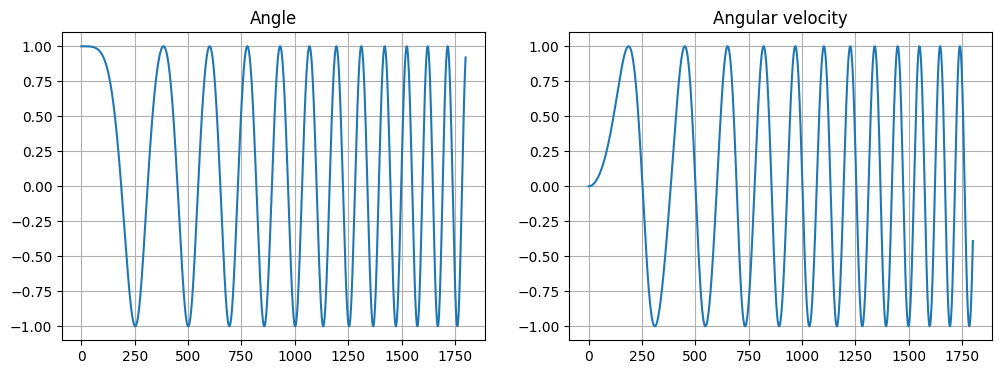

In [11]:
system = InvertedPendulumSystem(actor_type='continuous')
simulator = Simulator(
    system, N_steps=1800, step_size=0.003, state_init=np.array([0.0,0.0])
)
simulator.reset()

observations = []
actions = []
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()

    new_action = np.array([-5 * observation[0] + -2 * observation[1]])

    system.receive_action(new_action)
    observations.append(np.copy(observation))
    actions.append(np.copy(new_action))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 4)
ax1.plot(np.array(observations)[:, 0])
ax1.grid()
ax1.set_title("Angle")
ax2.plot(np.array(observations)[:, 1])
ax2.grid()
ax2.set_title("Angular velocity")

# LQR

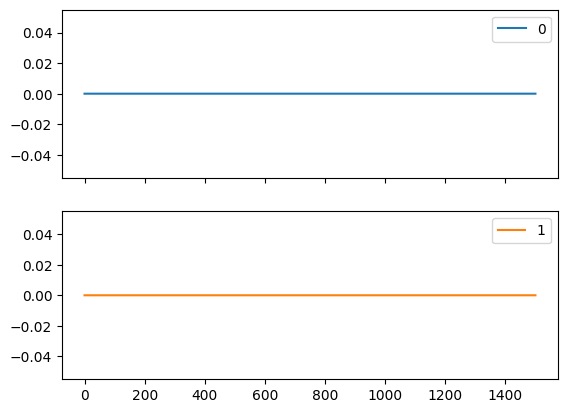

In [14]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystemLQR(actor_type='continuous', f=10.0)

simulator = Simulator(
    system, N_steps=1500, step_size=0.003, state_init=np.array([0.0, 0.0])
)

# This termination criterion never terminates episodes
trivial_termination_criterion = lambda *args: False

lqr = LQR(system.m, system.mc, system.l, system.g)

scenario = MonteCarloLQR(
    simulator=simulator,
    system=system,
    lqr=lqr,
    N_episodes=1, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=1, # You can change the number of iterations if you want
    termination_criterion=trivial_termination_criterion,
    discount_factor=1.0,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

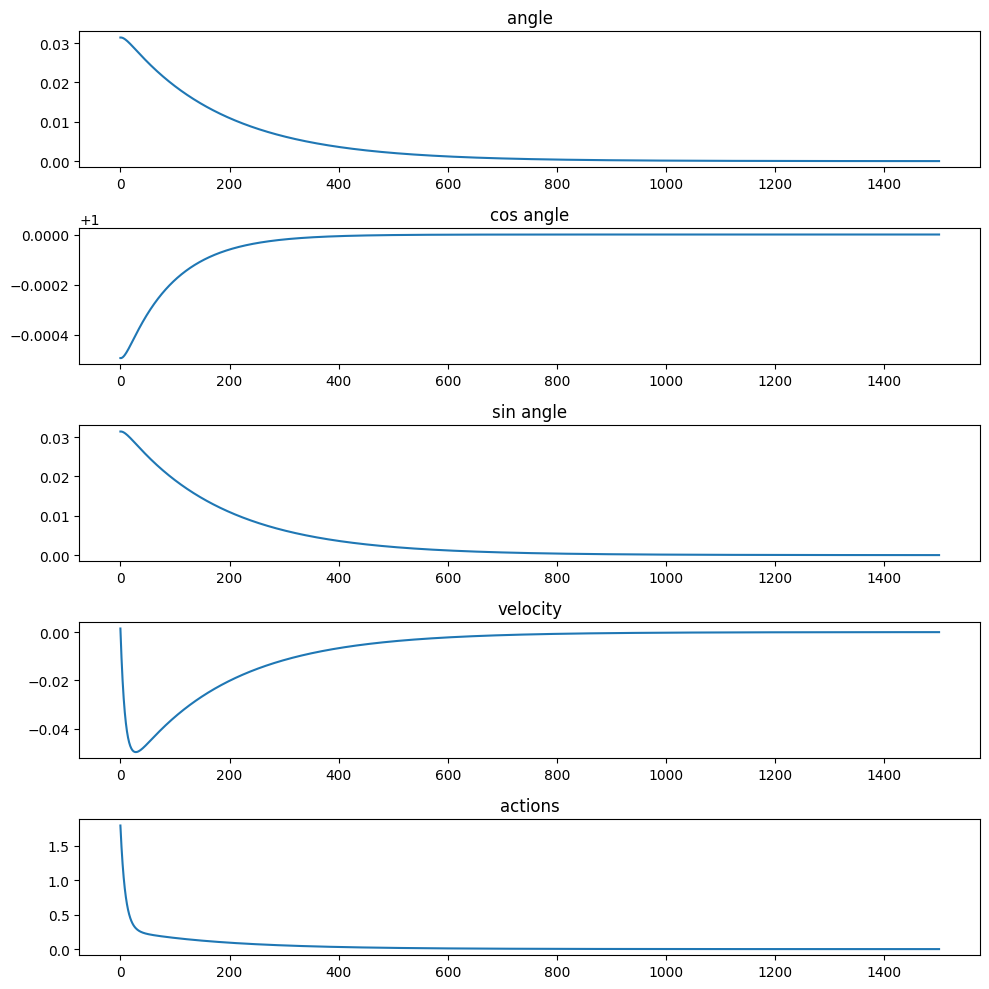

In [15]:
system = InvertedPendulumSystemLQR(actor_type='continuous', f=10.0)

simulator = Simulator(
    system, N_steps=1500, step_size=0.003, state_init=np.array([np.pi/100, 0.0])
)

simulator.reset()
observations = []
actions = []
i = 0
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()
    observations.append(np.copy(observation))
    new_action = lqr.get_action(observation)
    actions.append(new_action)

    system.receive_action(new_action)
    i += 1

observations = np.array(observations)
fig, axes = plt.subplots(5, 1, tight_layout=True, figsize=(10,10))

axes[0].plot(observations[:, 0])
axes[0].set_title('angle')
axes[1].plot(np.cos(observations[:, 0]))
axes[1].set_title('cos angle')
axes[2].plot(np.sin(observations[:, 0]))
axes[2].set_title('sin angle')
axes[3].plot(observations[:, 1])
axes[3].set_title('velocity')
axes[4].plot(actions)
axes[4].set_title('actions')
plt.show()

# Reinforce Discrete

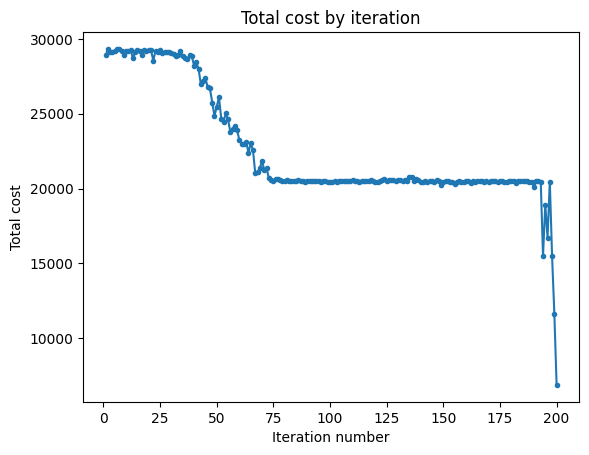

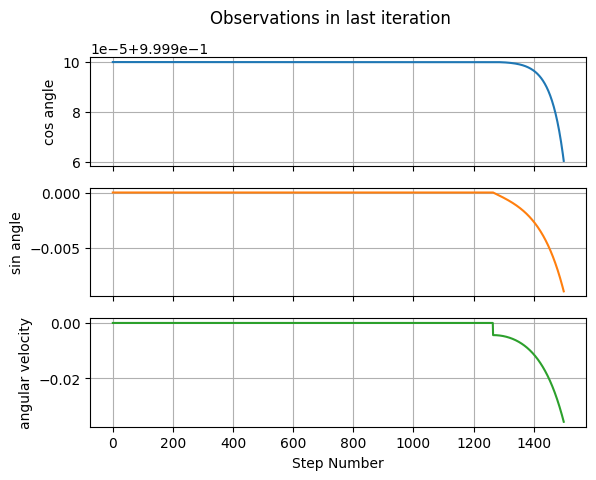

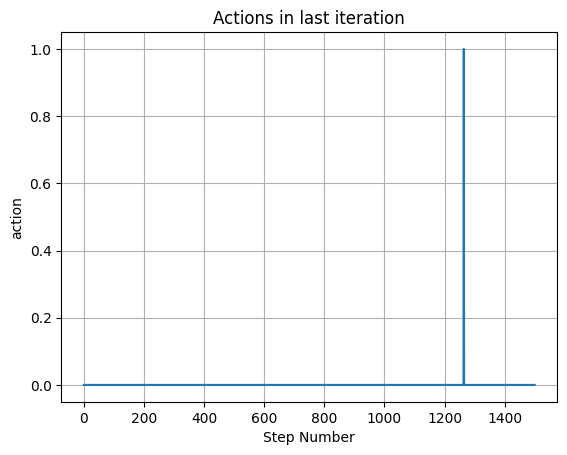

In [42]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystem(actor_type='discrete', f=10.0)

simulator = Simulator(
    system, N_steps=1500, step_size=0.003, state_init=np.array([0.0, 0.0])
)

model = DiscreteModel(dim_observation=system.dim_observation,
                    dim_action=system.dim_action,
                    dim_hidden=32,
                    n_hidden_layers=2,dim_output=3)

optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.005), # TRY TO FIND lr EMPIRICALLY
    #---------------------------------------------------------------------------
)

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_termination_criterion = lambda *args: False

scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    N_episodes=2, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=200, # You can change the number of iterations if you want
    termination_criterion=trivial_termination_criterion,
    discount_factor=1.0,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

# Reinforce Continuous

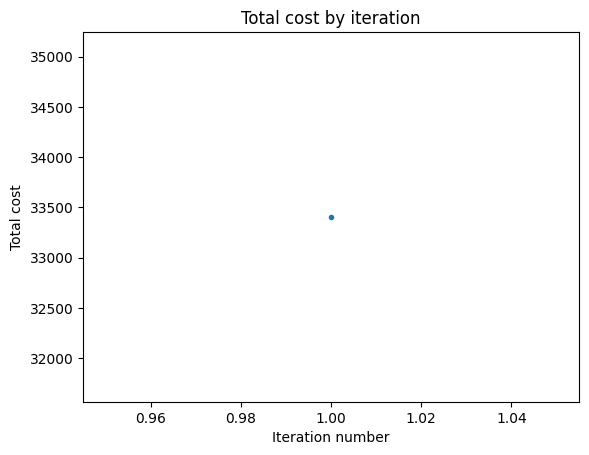

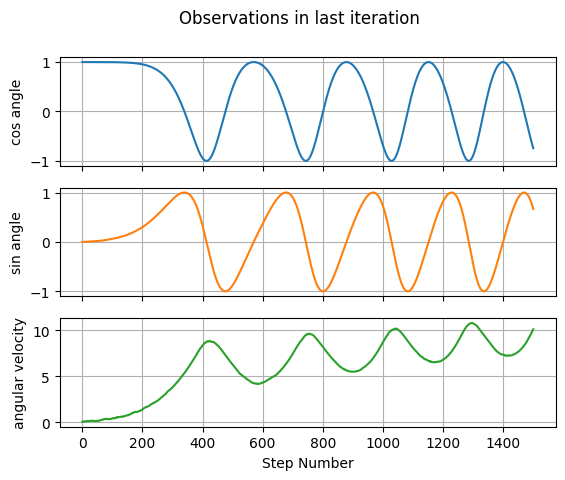

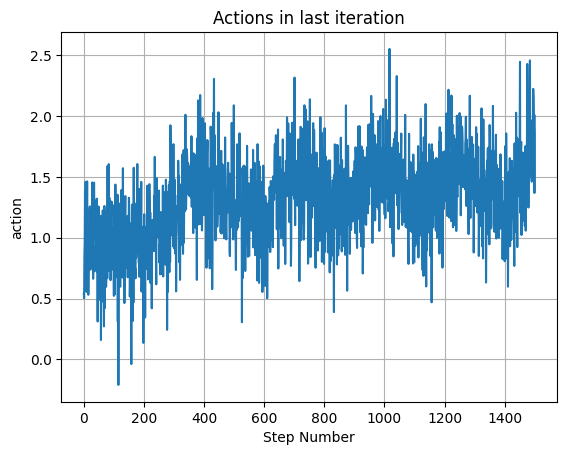

In [16]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystem(actor_type='continuous', f=10.0)

simulator = Simulator(
    system, N_steps=1500, step_size=0.003, state_init=np.array([np.pi, 0.0])
)

model = GaussianPDFModel(
    dim_observation=system.dim_observation,
    dim_action=system.dim_action,
    action_bounds=np.array([[-10, 10]]),
    scale_factor=1,  # TRY TO FIND scale_factor EMPIRICALLY
    dim_hidden=32, # TRY TO FIND dim_hidden EMPIRICALLY
    std=0.03, # TRY TO FIND STD EMPIRICALLY
    n_hidden_layers=2 # TRY TO FIND STD EMPIRICALLY
)

optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.005), # TRY TO FIND lr EMPIRICALLY
    #---------------------------------------------------------------------------
)

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_termination_criterion = lambda *args: False

scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    N_episodes=2, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=200, # You can change the number of iterations if you want
    termination_criterion=trivial_termination_criterion,
    discount_factor=1.0,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

# Limited Cartpole

In [ ]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystemCART(actor_type='discrete', f=10.0)

simulator = SimulatorLimited(
    system, N_steps=1500, step_size=0.003, state_init=np.array([0.0, 0.0])
)

model = DiscreteModel(dim_observation=system.dim_observation,
                    dim_action=system.dim_action,
                    dim_hidden=32,
                    n_hidden_layers=2,dim_output=3)

optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    #---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.005), # TRY TO FIND lr EMPIRICALLY
    #---------------------------------------------------------------------------
)

policy = PolicyREINFORCE(model, optimizer, is_with_baseline=True)


# This termination criterion never terminates episodes
trivial_termination_criterion = lambda *args: False

scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    N_episodes=2, # Increasing the number of episodes stabilizes learning, but you can manage it with N_episodes=1
    N_iterations=200, # You can change the number of iterations if you want
    termination_criterion=trivial_termination_criterion,
    discount_factor=1.0,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()